<a href="https://colab.research.google.com/github/100451013/100451013.github.io/blob/main/Predicciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importación de librerías necesarias

In [7]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from google.colab import files

#Carga de datos y visualización inicial

In [8]:
print("🔼 Sube los archivos: 'attrition_availabledata_19.csv' y 'attrition_competition_19.csv'")
uploaded = files.upload()

# Cargar datasets
df_train = pd.read_csv("attrition_availabledata_19.csv")
df_competicion = pd.read_csv("attrition_competition_19.csv")


🔼 Sube los archivos: 'attrition_availabledata_19.csv' y 'attrition_competition_19.csv'


Saving attrition_availabledata_19.csv to attrition_availabledata_19 (2).csv
Saving attrition_competition_19.csv to attrition_competition_19 (3).csv


#Preprocesamiento del conjunto de entrenamiento

In [9]:
# Separación de variables independientes y objetivo
X = df_train.drop(columns=["Attrition"])
y = df_train["Attrition"]

# Codificación de la variable objetivo
y = le.fit_transform(y)

# Detección de columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Imputación de valores faltantes
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')
X[num_cols] = imputer_num.fit_transform(X[num_cols])
X[cat_cols] = imputer_cat.fit_transform(X[cat_cols])
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))


#Preprocesamiento del conjunto de competición

In [10]:
X_competicion = df_competicion.copy()
X_competicion[num_cols] = imputer_num.transform(X_competicion[num_cols])
X_competicion[cat_cols] = imputer_cat.transform(X_competicion[cat_cols])
for col in cat_cols:
    X_competicion[col] = LabelEncoder().fit_transform(X_competicion[col].astype(str))


#Construcción del pipeline de preprocesamiento + modelo

In [12]:
# Transformador para variables categóricas
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

# Transformador para variables numéricas
num_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

# Preprocesador general
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Definición del modelo con SVM
modelo_final = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", SVC(class_weight="balanced", probability=True, random_state=451013))
])


#Entrenamiento y evaluación en conjunto de validación

In [13]:
# Entrenar con datos balanceados por SMOTE
modelo_final.fit(X_train_res, y_train_res)

# Predecir en conjunto de validación
y_val_pred = modelo_final.predict(X_val)

# Reporte de métricas
print("🔎 Classification Report (validación):")
print(classification_report(y_val, y_val_pred))

# Balanced Accuracy
bac = balanced_accuracy_score(y_val, y_val_pred)
print(f"🎯 Balanced Accuracy en validación: {bac:.4f}")


🔎 Classification Report (validación):
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       493
           1       0.62      0.73      0.67        95

    accuracy                           0.88       588
   macro avg       0.78      0.82      0.80       588
weighted avg       0.89      0.88      0.89       588

🎯 Balanced Accuracy en validación: 0.8206



Este informe revela que el modelo tiene un rendimiento general bastante bueno, con un 88% de precisión al clasificar los datos de validación. Se destaca especialmente en la clase mayoritaria (clase 0), donde logra un F1-score de 0.93. Sin embargo, en la clase minoritaria (clase 1), el rendimiento no es tan alto, con un F1-score de 0.67, lo que sugiere que el modelo enfrenta más dificultades para identificar correctamente estos casos. A pesar de esto, la Balanced Accuracy de 0.82 muestra un desempeño razonablemente equilibrado entre ambas clases, considerando el desbalance en los datos.

#Visualización: Matriz de confusión


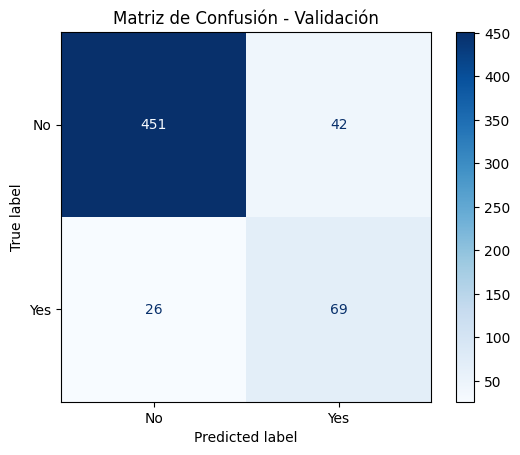

In [14]:
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Validación")
plt.show()


#Entrenamiento

In [15]:
# Entrenar el modelo final con todos los datos
modelo_final.fit(X, y)

# Guardar el modelo entrenado
joblib.dump(modelo_final, "modelo_final.pkl")
print("✅ Modelo final guardado como 'modelo_final.pkl'")


✅ Modelo final guardado como 'modelo_final.pkl'


#Prediccion

In [16]:
# Predecir sobre el conjunto de competición
predicciones = modelo_final.predict(X_competicion)

# Guardar las predicciones en un archivo CSV
df_preds = pd.DataFrame(predicciones, columns=["Prediccion"])
df_preds.to_csv("predicciones.csv", index=False)
print("✅ Predicciones guardadas como 'predicciones.csv'")


✅ Predicciones guardadas como 'predicciones.csv'


#Visualizacion predicciones

🔮 Primeras 10 predicciones sobre el conjunto de competición:
   Prediccion
0           0
1           0
2           0
3           1
4           1
5           0
6           0
7           0
8           0
9           0

📊 Distribución general de predicciones:
Prediccion
0    1125
1     345
Name: count, dtype: int64


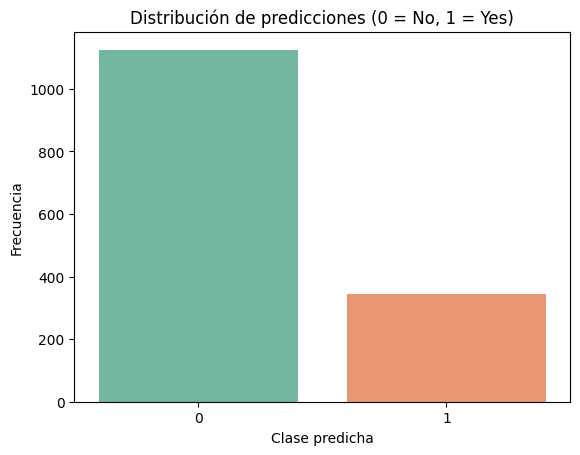

In [18]:
# Mostrar primeras 10 predicciones
print("🔮 Primeras 10 predicciones sobre el conjunto de competición:")
print(df_preds.head(10))

# Mostrar distribución de predicciones
print("\n📊 Distribución general de predicciones:")
print(df_preds["Prediccion"].value_counts())

# Visualización rápida
# Visualización sin warning
sns.countplot(data=df_preds, x="Prediccion", hue="Prediccion", palette="Set2", legend=False)
plt.title("Distribución de predicciones (0 = No, 1 = Yes)")
plt.xlabel("Clase predicha")
plt.ylabel("Frecuencia")
plt.show()



Visualizamos las diez primeras filas para ver si los resultados pordrían ser adecuados